# Segmentation Transformers for Tumor Segmentation

The objective is to implement an architechture that blends UNETs and transformers architechtures: TransUNET, Proposed by Jieneng Chen et al in 2021. The original papaer uses it to perform multi organ segmentation, here, we'll try to do it on Lower Grade Gliomas (Data available at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) <br>

> We argue that Transformers can serve as strong encoders for medical image segmentation tasks, with the combination of U-Net to enhance finer
> details by recovering localized spatial information. TransUNet achieves
> superior performances to various competing methods on different medical
> applications including multi-organ segmentation and cardiac segmentation. Code and models are available at https://github.com/Beckschen/TransUNet
<br>
<br>
<p align='center'>
    <img src='images/sc01.jpg'/>
</p>

## 0. libraries

In [17]:
import tensorflow_io as tfio
import numpy as np 
import pandas as pd 
import PIL
import glob
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('dark_background')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

In [18]:
tf.config.experimental.set_memory_growth( tf.config.list_physical_devices()[1], enable=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Example-Label pairing

Identify examples and labels

In [19]:
# get the images file paths
filenames = []
for path, currentDirectory, files in os.walk("lgg-mri-segmentation"):
    for file in files:
        if file.endswith('.tif'):
            filenames.append(path + '/' + file)
filenames = sorted(filenames)

original = []
mask = []
for image in filenames:
    if image.endswith('mask.tif'):
        mask.append(image)
    else:
        original.append(image)

mask = sorted(mask, key = len)
original = sorted(original, key = len)
data = pd.DataFrame({'original': original, 'mask':mask})
data.head(10)

nSamples = len(original)
print('dataset features a total of: ',nSamples,' labelled examples')

dataset features a total of:  3929  labelled examples


Load and show a train example

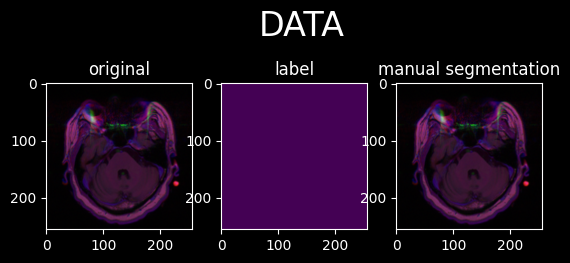

each example has dimension:  (256, 256)
each array has shape:     (256, 256, 3)


In [20]:
idx = np.random.randint(0,nSamples-1)
img = PIL.Image.open(data['original'][idx])
lbl = PIL.Image.open(data['mask'][idx])

fig, axs = plt.subplots(1,3)
axs[0].imshow(img), axs[0].set_title('original')
axs[1].imshow(lbl), axs[1].set_title('label')
axs[2].imshow(img), axs[2].set_title('manual segmentation')
axs[2].imshow(lbl, alpha=0.5 * (np.array(lbl) > 0))
fig.suptitle('DATA', x=0.525, y=0.8, fontsize=24)
plt.show()

img_size = np.array(img).shape[:2]
img_shape= np.array(img).shape

print('each example has dimension: ', img_size)
print('each array has shape:    ', img_shape)

In [21]:
x_train, x_test = train_test_split(data, test_size = 0.2, shuffle=True)

Data loading, preprocessing and augmentation using Image Generators

In [22]:
BATCHSIZE = 14
def preprocess(img, mask):
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_gen(x):
    gen = ImageDataGenerator(
        rescale=1./255
    )

    img_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='original',
                                      class_mode=None,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      rotation_range=360,
                                      target_size=img_size,
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    
    mask_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='mask',
                                      class_mode=None, 
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      rotation_range=360,
                                      target_size=img_size,
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    generator = zip(img_gen, mask_gen)
    
    for (img, mask) in generator:
        img, mask = preprocess(img, mask)
        yield (img, mask)

train = create_gen(x_train)
val = create_gen(x_test)

## 3. Model creation: Transformer 

### 3.1: Patch encoding
The first transformer block recieves the feature maps coming out from the Convolutional layers. We can interpret the activation of the filters as some sort of patches which we can enhance by applying attention. The Vision Transformers works well with (hidden) embeddings as input so what we are required to do is:
 - flatten the "patches";
 - apply a linear projection in a space of dimension `d_model`;
 - convert them to embeddings;
 - add the positional encoding;

Let's define the `Positional Encoding` first. When the first Transformer architecture was presented with the paper 'Attention is all you need' they proposed an encoding based on sinusoidal waves. They argued that due to the linear nature of the transformations inside a transformer, an encoding of this kind would be more suited. In Vision Transformers, instead, the embeddings are initialized randomly:
> Other than that, the position embeddings at initialization time carry no information <br>
> about the 2D positions of the patches and all spatial relations between the patches have to be learned<br>
> from scratch. <br>
> [an image is worth 16x16 words: transformers for image recoginition at scale](https://arxiv.org/abs/2010.11929)

Here we are still going to use randomly initialized embeddings, however we are not going to use inductive bias, since a binary segmentation problem.

The Class ``PatchEncoder`` will convert the feature maps in embeddings with positional encoding added

> We map the vectorized patches xp into a latent D-dimensional embedding space using a trainable linear projection.<br>
> [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)

In [23]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, d_model):
        super().__init__()
        self.d_model = d_model
        self.num_patches = num_patches
        self.projection = layers.Dense(units=d_model)                                      
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=d_model)   
        self.flatten = layers.Reshape((num_patches,-1)) 

    def call(self, x): 
        x = self.flatten(x)                                                                                    
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = self.projection(x)                                          
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))                          
        encoded = x + self.position_embedding(positions)
        return encoded

for comparison, in NLP Transformers, the embedding shape was: `(batch_size) x (query_length) x (d_model)` <br>
here, we are dealing with a query length equals to n_pathces so: `(batch_size) x (n_patches) x (d_model)` <br>
Dimensions check out.<br>
[Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)

### 3.2 attention

In [24]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.layer_output = None

  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
     
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

### 3.3 Multi Layer Perceptron layer
We'll adhere to the original study:
> For the “base” model, the hidden
> size D, number of layers, MLP size, and number of heads are set to be 12, 768,
> 3072, and 12, respectively while those hyperparamters for “large” model are 24,
> 1024, 4096, and 16.<br>
> [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)

In [25]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.layer_output = None
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()
    
  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    self.layer_output = x

    return x

### 3.4 Transformer block
The authors work with pretrained ViT. We'll try to train them from scratch instead. 
> For the hybrid encoder design, we combine ResNet-50 and ViT,
> denoted as “R50-ViT”, throught this paper. All Transformer backbones (i.e.,
> ViT) and ResNet-50 (denoted as “R-50”) were pretrained on ImageNet <br>
[TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)
  
  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    
    return x


## Model Hyper-Parameters

Using parameters similar to the original study:

In [27]:
n_tf_layers = 4 # original got 12 but they don't fit
dff = 3072
d_model = 768 
num_heads = 8
n_classes = 1

In [28]:
img_input = layers.Input(img_shape)

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)
block_1_out = x

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)
block_2_out = x

# Block 3
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(x)
block_3_out = x

# Transformer Blocks
x = PatchEncoder(num_patches=x.shape[-1], d_model=d_model)(x)
for _ in range(n_tf_layers):
    x = EncoderLayer(d_model=d_model, dff=dff, num_heads=num_heads)(x)

# Channel Size Reduction
x = layers.Reshape((16, 16, -1))(x)
x = layers.Conv2D(512, (1, 1), padding='same', name='block_hid_conv1')(x)
x = layers.BatchNormalization()(x)

# Up Sampling 1
x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_3_out])
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Up Sampling 2
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_2_out])
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)


# Up Sampling 3
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_1_out])
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Up Sampling 4
x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = layers.Conv2D(n_classes, (3, 3), activation='sigmoid', padding='same')(x)

## 4. Model Training

There are some options here. For transformers architecture, a dynamic learning rate along with early stopping were first chosen:
> We train all models, including ResNets, using Adam (Kingma & Ba, 2015) with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, whic we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting). We use a linear learning rate warmup and decay.<br>
> [an image is worth 16x16 words: transformers for image recoginition at scale](https://arxiv.org/abs/2010.11929)



However, the authors of the TransUnet use a static strategy:
> Models are trained with SGD optimizer with learning rate 0.01, momentum 0.9 and weight decay 1e-4. The
> default batch size is 24 and the default number of training iterations are 20k<br>
> [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)

We'll try to stick to the TransUNET study

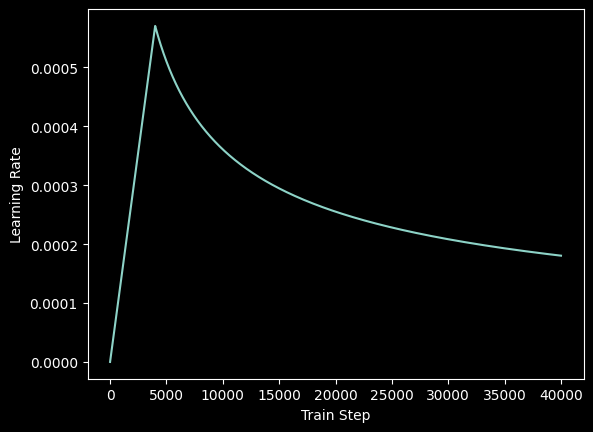

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer_ViT = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

Here is the adaptive learning rate mentioned before if you want to experiment with it.

In [30]:
optimizer_transunet = tf.keras.optimizers.SGD(learning_rate=0.01, 
                                              momentum=0.9)

In [31]:
model = Model(img_input, x)
model.compile(optimizer=optimizer_transunet, loss='binary_crossentropy')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

### Fit
Due to the number of parameters and the fact we are training everything from scratch, we are going to increase the training epochs. We'll se where this brings us.<br>
*Note: when increasing the number of epochs, one should implement also call backs measure for preacustion*

In [32]:
history = model.fit(train, 
          epochs=2000, 
          validation_data= val,
          steps_per_epoch= len(x_train)// BATCHSIZE,
          validation_steps= len(x_test) // BATCHSIZE,
          verbose=1
          )

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/2000
224/224 [==============================] - ETA: 0s - loss: 0.0521Found 786 validated image filenames.
Found 786 validated image filenames.
224/224 [==============================] - 61s 259ms/step - loss: 0.0521 - val_loss: 0.0504
Epoch 2/2000
224/224 [==============================] - 59s 259ms/step - loss: 0.0251 - val_loss: 0.0390
Epoch 3/2000
224/224 [==============================] - 58s 259ms/step - loss: 0.0199 - val_loss: 0.0189
Epoch 4/2000
224/224 [==============================] - 57s 257ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 5/2000
224/224 [==============================] - 58s 258ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 6/2000
224/224 [==============================] - 58s 258ms/step - loss: 0.0124 - val_loss: 0.0128
Epoch 7/2000
224/224 [==============================] - 57s 254ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 8/2000
224/224 [============================

# 5. Evaluation

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
if not(os.path.exists('TransUNET_output')):
    os.mkdir('TransUNET_output')

nSaveImages = 50
for im in range(nSaveImages):
    rows = 3
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize = (60, 60))    

    for i in range(rows):

        idx = np.random.randint(0,nSamples-1)
        img = PIL.Image.open(data['original'][idx])
        lbl = PIL.Image.open(data['mask'][idx])
        
        
        pred = model.predict(np.expand_dims(np.array(img)/255,0))
        
        axs[i,0].imshow(img), axs[i,0].set_title('original',fontsize=50)
        axs[i,1].imshow(lbl), axs[i,1].set_title('label',fontsize=50)

        axs[i,2].imshow(img), axs[i,2].set_title('automatic segmentation', fontsize=50)
        axs[i,2].imshow(pred[0], alpha=((pred[0] > 0.1) * 0.5)[:,:,0])

        axs[i,3].imshow(pred[0], cmap='gray'), axs[i,3].set_title('predicted',fontsize=50)
        
    fig.suptitle('MODEL EVALUATION', fontsize=50)
    import uuid
    figname = uuid.uuid1()
    fig.savefig('TransUNET_output/'+str(figname))
    plt.close()